In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [2]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
ripples = mat_to_return['ripples']


prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



import place_field_analysis as pf
reload(pf)

cell_cols = cell_cols_d['pyr']
fr_map_d,count_d,occu_d,bins_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=5,nbins=100,smth_in_bin=2.5)
spk_beh_df['lin_binned'],bins = pd.cut(spk_beh_df['lin'],100,retbins=True,labels=False)


# get fields
fr_map_peaks_d = {}
field_res_d = {}
for key in fr_map_d.keys():

    fr_map = fr_map_d[key]
    count = count_d[key]
    occu = occu_d[key]
    field_res_d[key] =pf.get_field_peaks_one_trialtype(fr_map,count,occu)
    
# turn tensor into df!!!
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols_d['pyr'],trialtype_key='visitedArm',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial =  {}
for tt in [0,1]:
    tensor=fr_map_dict[tt][0]
    posbin_l = np.arange(tensor.shape[1])
    index=pd.MultiIndex.from_product([cell_cols_d['pyr'],posbin_l])
    fr_map_trial_onetrialtype = pd.DataFrame(tensor.reshape(-1,tensor.shape[-1]),index=index)
    fr_map_trial[tt] = fr_map_trial_onetrialtype

reload(pf)
field_params_trial=pf.get_field_params_trial(fr_map_trial[0],field_res_d[(0,0)]['all_fields'])

In [59]:
embed_n = 5
X = scipy.stats.zscore(field_params_trial.loc['fr'],axis=1)
X_embed=pd.concat([X.shift(-i,axis=1).stack() for i in range(embed_n)],axis=1).dropna(axis=0)

In [17]:
X.shift(0,axis=1).stack()

3    0  0      0.008736
        1      0.266130
        2      1.155172
        3      0.000000
        4      0.592301
                ...    
480  0  28     4.200531
        29    13.722047
        30     9.772024
        31    13.870261
        32    10.515109
Length: 10164, dtype: float64

In [29]:
from sklearn.mixture import GaussianMixture

In [74]:
gmm = GaussianMixture(n_components=10)
gmm.fit(X_embed)

GaussianMixture(n_components=10)

In [132]:
from scipy.cluster import hierarchy

In [137]:
Z = hierarchy.linkage(X_embed,"average",metric="cosine")
threshold=0.5
C = hierarchy.fcluster(Z,threshold,criterion="distance")

In [140]:
X_embed_fit = copy.copy(X_embed)
X_embed_fit['label'] = C

In [61]:
gmm.predict(X_embed)

array([1, 1, 1, ..., 3, 3, 2])

In [62]:
gmm.means_.shape

(4, 5)

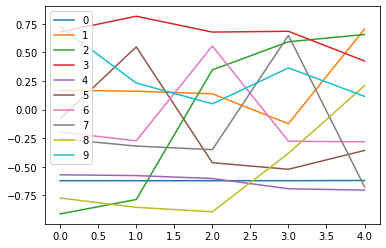

In [75]:
%matplotlib inline
plt.plot(gmm.means_.T)
plt.legend(range(gmm.means_.shape[0]))

In [ ]:
change_big_enough=gmm.means_.max(axis=1)-gmm.means_.min(axis=1) > 0.5

In [113]:
X_embed_fit = copy.copy(X_embed)
X_embed_fit['label'] = gmm.predict(X_embed)
posterior=gmm.predict_proba(X_embed)[:,change_big_enough]
posterior_cols= np.array([f'post_{i}' for i in range(gmm.means_.shape[0])])[change_big_enough]
posterior = pd.DataFrame(posterior,index=X_embed_fit.index,columns=posterior_cols)
X_embed_fit = pd.concat([X_embed_fit,posterior],axis=1)

<AxesSubplot:>

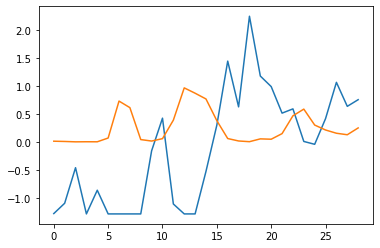

In [73]:
X_embed_fit.loc[3,0][0].plot()
X_embed_fit.loc[3,0]['post_3'].plot()

In [117]:
moments_mask=X_embed_fit[posterior_cols].max(axis=1) > 0.95


In [91]:
X_embed_fit.loc[moments_mask].iloc[ii]

0         2.857015e-01
1        -2.606397e-01
2        -3.777253e-01
3         5.209684e+00
4        -5.224251e-01
label     7.000000e+00
post_0    0.000000e+00
post_1    4.959818e-10
post_2    3.494339e-04
post_3    2.885178e-03
post_4    1.751412e-67
post_5    7.519725e-19
post_6    2.798215e-13
post_7    9.967653e-01
post_8    1.563716e-09
post_9    9.382420e-08
Name: (38, 0, 28), dtype: float64

In [118]:
X_embed_fit.loc[moments_mask]

0         1         2         3         4  label  \
37  1 8  -1.581250  0.600117 -0.511167 -1.609670  2.053929      1   
38  0 27 -0.658766  0.285701 -0.260640 -0.377725  5.209684      1   
      28  0.285701 -0.260640 -0.377725  5.209684 -0.522425      7   
48  0 6  -2.472918 -0.050603 -1.455657 -1.664879  1.348703      1   
    1 1  -1.437888 -1.162519 -0.095235  1.910858  2.065190      2   
...            ...       ...       ...       ...       ...    ...   
451 0 17  4.491970 -0.249989 -0.433085 -0.433085 -0.433085      9   
465 0 10 -0.382111 -0.382111 -0.382111  4.079076 -0.382111      7   
      11 -0.382111 -0.382111  4.079076 -0.382111  3.480443      2   
      14 -0.382111  3.480443 -0.382111 -0.382111 -0.382111      5   
      15  3.480443 -0.382111 -0.382111 -0.382111 -0.382111      9   

                post_1        post_2        post_5        post_6  \
37  1 8   9.809001e-01  1.195329e-03  1.679220e-03  2.135296e-04   
38  0 27  9.971939e-01  1.310833e-04  1.593291e-11  4.456579e-14   
      28  4.959818e-10  3.494339e-04  7.519725e-19  2.798215e-13   
48  0 6   9.673436e-01  9.487147e-03  1.203637e-02  4.437973e-03   
    1 1   4.056741e-03  9.610673e-01  3.238036e-06  4.639378e-06   
...                ...           ...           ...           ...   
451 0 17  5.604710e-05  1.168788e-23  4.989188e-06  9.094888e-08   
465 0 10  2.205608e-07  1.019376e-02  2.022239e-12  4.716362e-09   
      11  1.615259e-05  9.929106e-01  1.299048e-18  1.139647e-07   
      14  1.023398e-03  3.718792e-15  9.697012e-01  2.134311e-05   
      15  1.432187e-03  1.089978e-16  4.068806e-04  3.053001e-05   

                post_7        post_8        post_9  
37  1 8   7.699263e-09  2.833701e-07  2.166534e-04  
38  0 27  1.033403e-31  2.491790e-03  6.974514e-10  
      28  9.967653e-01  1.563716e-09  9.382420e-08  
48  0 6   1.282460e-05  4.566976e-08  5.087468e-04  
    1 1   2.693412e-06  1.160390e-03  2.469111e-03  
...                ...           ...           ...  
451 0 17  1.966033e-08  4.080555e-38  9.654469e-01  
465 0 10  9.777606e-01  9.791032e-07  2.493184e-05  
      11  3.092814e-24  1.324380e-40  1.437700e-07  
      14  1.311763e-06  4.564641e-38  7.623175e-06  
      15  6.495235e-06  3.417230e-25  9.506416e-01  

[105 rows x 13 columns]

In [93]:
X_embed_fit.loc[moments_mask].index[ii]

(38, 0, 28)

6


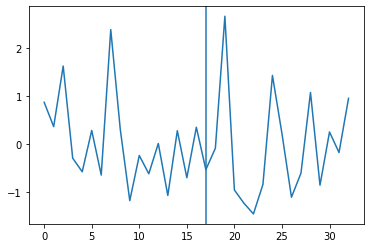

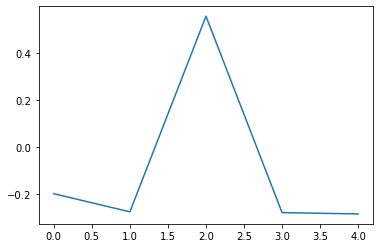

In [131]:
ii=11
neuron,field,trial = X_embed_fit.loc[moments_mask].index[ii]
# X_embed_fit.loc[moments_mask].iloc[ii].loc[0:4].plot()
label = int(X_embed_fit.loc[moments_mask].iloc[ii]['label'])
print(label)
ax=X.loc[neuron,field].plot()
ax.axvline(trial)
plt.figure()
plt.plot(gmm.means_[label])